# Задание 1 (10 баллов)

Придумайте 5 категорий и сгенерируйте по 6 картинок на каждую (всего 30) с помощью генеративной diffusion модели и попытайтесь восстановить изначальное разбиение на категории из эмбеддингов картинок с помощью модели CLIP и любого алгоритма кластеризации. Проанализируйте результаты. 

- Категории могут быть абсолютно любыми, главное чтобы они были действительно (по вашему мнению) визуально отличимы друг от друга (примеры: `архитектура`, `собаки`, `машины`, `свитеры`)
- Можете использовать `segmind/SSD-1B` из семинара или какую-то другую модели с huggingface (например, `stabilityai/stable-diffusion-xl-base-1.0`, `stabilityai/stable-diffusion-2-1`). 
- каждый промпт должен быть полностью уникальным; внутри одного промпта и из промпта в промпт могут повторяться только предлоги/частицы/артикли; минимальная длина промпта - 10 слов; сохраните все промпты, которые вы использовали
- помимо промпта вам также нужно использовать параметры `guidance_scale`, `negative_prompt`, `height`, `width` (в разных промптах значения должны быть разными)
- используйте `generator = torch.Generator('cuda').manual_seed(12363)` для фиксации random_seed и воспроизводимости (*само значение вы можете подбирать в каждом отдельном случае пока не получится хорошая картинка*)
- сгенерированные картинки не должны быть идеальными, но должны хоть как-то отражать промпт; если у вас получается совсем что-то непонятное, то попытайтесь еще раз с другим seed или остальными параметрами;
- для наглядности напечатайте все картинки, но используйте to_256 из семинара, чтобы не перегружать ноутбук
- можете использовать любую clip модель (например `clip-vit-base-patch32` из семинара) для создания эмбедингов картинок (промпты эмбеддить не нужно)
- можете использовать любой алгоритм кластеризации, но лучше использовать алгоритмы с указанием количества кластеров; в целом постарайтесь получить как можно более хороший результат (даже если кластеризация совсем неверная, должна прослеживаться какая-то логика, результат не должен быть случайным);
- оценивайте качество кластеризации с помощью метрики ARI; лучшую модель разберите визуально - опишите как минимум 3 паттерна (не обязательно корректных), которые модель смогла уловить, а также 3 паттерна (если они есть), которые модель не распознала.

In [228]:
from tqdm import tqdm

In [1]:
from torchvision import transforms
# это вспомогательные функции чтобы картинки были поменьше
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

In [2]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch
import numpy as np

model_id = "stabilityai/stable-diffusion-2-1-base"

scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
generator=torch.Generator('cuda')

In [240]:
image_prompts = [
    {"prompt": "plane, at the center, side view, flowers around",
    "negative_prompt": "grayscale, abstract, deviant art, small",
    "guidance_scale": 6,
    "num_inference_steps": 40,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(12363),
    },
    {"prompt": "flying train, sky, windy, abstract, high quality, grayscale",
    "negative_prompt": "red, black",
    "guidance_scale": 14,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(12363),
    },
    {"prompt": "car, night city, backlight, squared, huge",
    "negative_prompt": "window, bright",
    "guidance_scale": 2,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(12363),
    },
    {"prompt": "truck, mountains, crash, broken, red, wooden",
    "negative_prompt": "wires,",
    "guidance_scale": 5,
    "num_inference_steps": 40,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(12363),
    },
    {"prompt": "boat at the center, stuck at the coast, loch ness monster in the lake, weird, broken",
    "negative_prompt": "normal, realistic, red",
    "guidance_scale": 4,
    "num_inference_steps": 25,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(11),
    },
    {"prompt": "helicopter in the cave lit with torchlight",
    "negative_prompt": "normal, realistic",
    "guidance_scale": 4,
    "num_inference_steps": 25,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(12),
    },
    {"prompt": "baskerville dog in a circle, futuristic",
    "negative_prompt": "cartoon, handdrawn",
    "guidance_scale": 4,
    "num_inference_steps": 25,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "russian borzoi, cubic, picasso",
    "negative_prompt": "blue",
    "guidance_scale": 6,
    "num_inference_steps": 35,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(48),
    },
    {"prompt": "tibetan mastiff with the sunglasses, seashore,",
    "negative_prompt": "sunny",
    "guidance_scale": 10,
    "num_inference_steps": 35,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(670),
    },
    {"prompt": "beagle at the captain's bridge, foreground, storm, aivazovsky",
    "negative_prompt": "sunny, boat, sailboat, people, art",
    "guidance_scale": 4,
    "num_inference_steps": 45,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(232),
    },
    {"prompt": "samoyed under the palm tree, android tablet with graphs in its paws",
    "negative_prompt": "saturation, walls, weather, sand, photorealistic",
    "guidance_scale": 18,
    "num_inference_steps": 45,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "detective bull terrier in a coat, dragons in the background, rainy day, painting",
    "negative_prompt": "cartoonish",
    "guidance_scale": 25,
    "num_inference_steps": 45,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(876),
    },
    {"prompt": "seashell on a plate, green border",
    "negative_prompt": "cartoonish",
    "guidance_scale": 25,
    "num_inference_steps": 45,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(876),
    },
    {"prompt": "shark with a cowboy hat on, realistic, art",
    "negative_prompt": "cartoon, people",
    "guidance_scale": 3,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(567),
    },
    {"prompt": "sea horse in a bathtub",
    "negative_prompt": "cartoon, rocks",
    "guidance_scale": 7,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(7834),
    },
    {"prompt": "flock of colored fish under the rock",
    "negative_prompt": "noisy, blue",
    "guidance_scale": 7,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(7834),
    },
    {"prompt": "octopus driving the car,  inverted lighting",
    "negative_prompt": "",
    "guidance_scale": 5,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(23),
    },
    {"prompt": "orca whale in a sea",
    "negative_prompt": "mountains, sky",
    "guidance_scale": 5,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(56),
    },
    {"prompt": "sofa, mid thirties, panoram windows, red dawn lighting",
    "negative_prompt": "soft light, white",
    "guidance_scale": 15,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(56),
    },
    {"prompt": "a bunch of green poufs in a room, dawn",
    "negative_prompt": "people, auqarium",
    "guidance_scale": 3,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(2),
    },
    {"prompt": "table and a couple of chairs outdoors, night",
    "negative_prompt": "",
    "guidance_scale": 3,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(2),
    },
    {"prompt": "minimalist nordic tabouret",
    "negative_prompt": "soft light, hidden door, pencil",
    "guidance_scale": 3,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(2),
    },
    {"prompt": "gigantic intricate wooden table with ancient engravings in a dungeon, ambient light",
    "negative_prompt": "",
    "guidance_scale": 6,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(222),
    },
    {"prompt": "broken steel table and chair legs scattered on a floor",
    "negative_prompt": "sand",
    "guidance_scale": 20,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "twisted spiral countryhouse, modern architecture",
    "negative_prompt": "glass, steel, windows",
    "guidance_scale": 25,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "old spanish cathedral, earth above, gargoiles flying around",
    "negative_prompt": "",
    "guidance_scale": 7,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "finnish housing, winter",
    "negative_prompt": "dogs, white sky",
    "guidance_scale": 7,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "weird witchcraft shack, green evaporations, realistic, broken forest",
    "negative_prompt": "skulls",
    "guidance_scale": 7,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(42),
    },
    {"prompt": "art deco, skyscraper entrance, street view, noir, dim light",
    "negative_prompt": "men, modern, empty",
    "guidance_scale": 25,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(123),
    },
    {"prompt": "alpine village under the highway, street, highlights",
    "negative_prompt": "soft light, ",
    "guidance_scale": 5,
    "num_inference_steps": 50,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(123),
    },
]

In [244]:
from itertools import chain

In [249]:
classes = list(chain.from_iterable([np.arange(6) for x in range(5)]))

In [241]:
images = []

for prompt in image_prompts:

    images.append(pipe(**prompt).images[0])

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

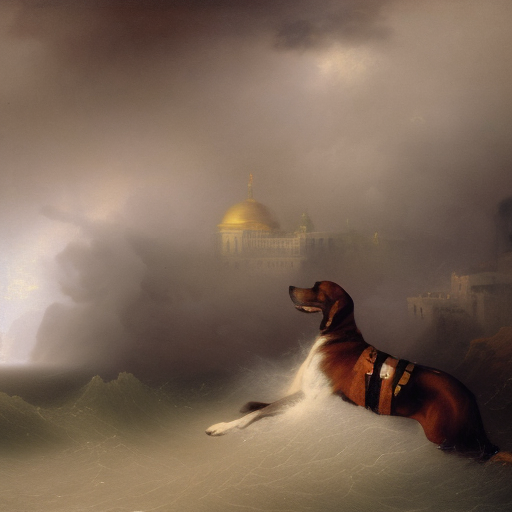

In [239]:
pipe(**{"prompt": "beagle at the captain's bridge, foreground, storm, aivazovsky",
    "negative_prompt": "sunny, boat, sailboat, people, art",
    "guidance_scale": 4,
    "num_inference_steps": 45,
    "height": 512,
    "width": 512,
    "generator": generator.manual_seed(232),
    }).images[0]

In [231]:
from matplotlib import pyplot as plt

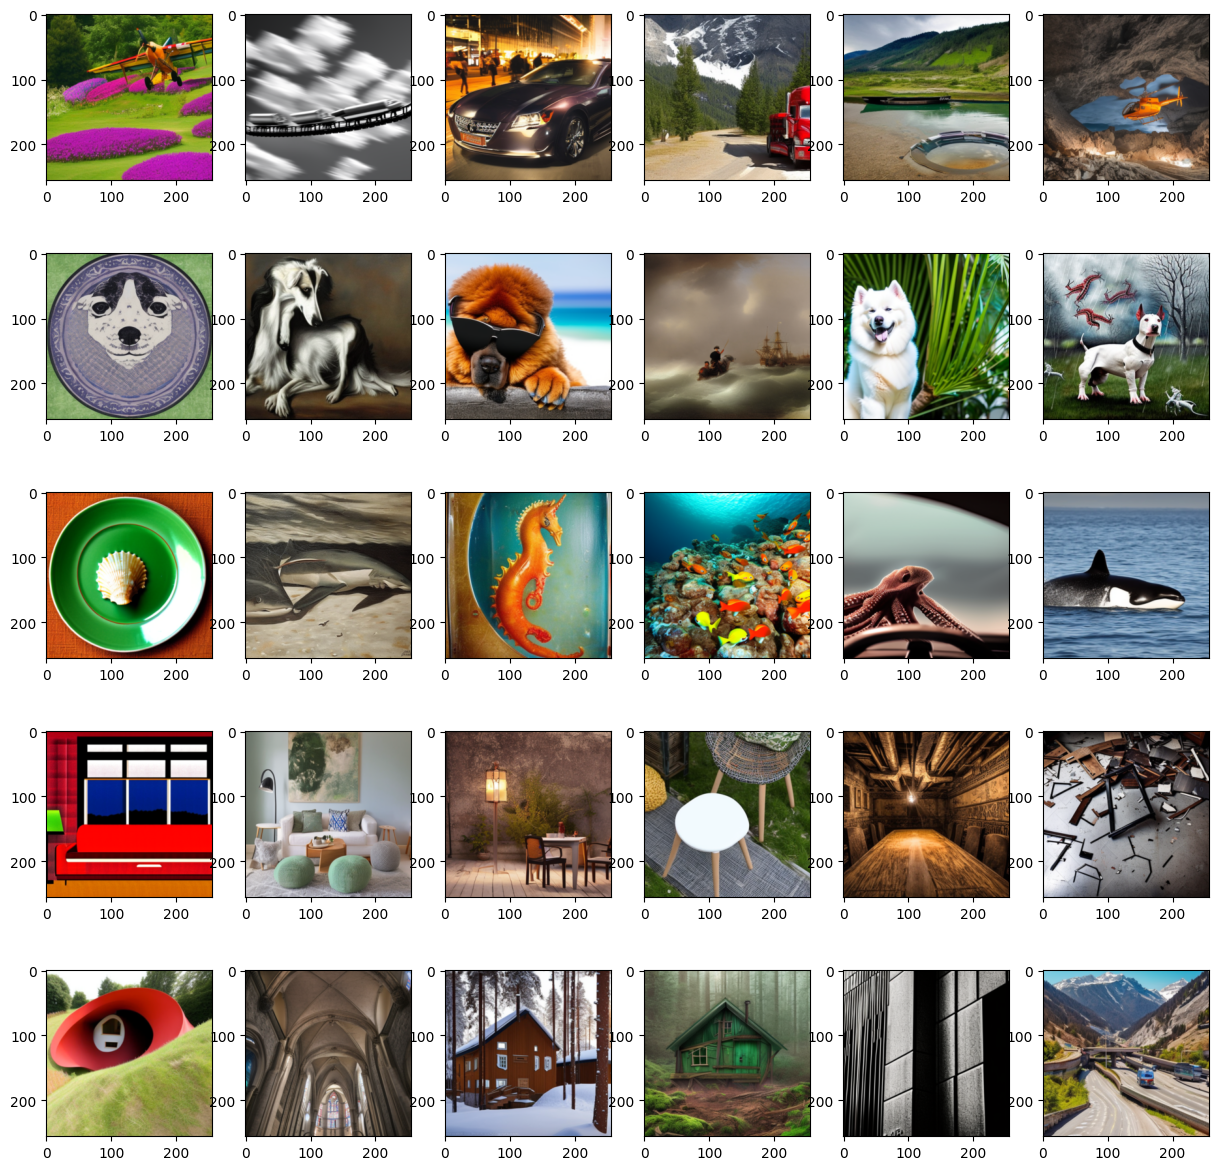

In [252]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(15, 15))

for i in range(5):
    for j in range(6):
        ax[i][j].imshow(to_256(images[6*i+j]))

In [253]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [274]:
inp = processor(images=[to_256(image) for image in images], return_tensors="pt")

In [285]:
image_embeddings = model.get_image_features(**inp).detach().cpu().numpy()

### Clusterization

In [279]:
from sklearn.decomposition import SparsePCA, KernelPCA, TruncatedSVD
from umap import UMAP

In [280]:
k_pca = KernelPCA(n_components=3, kernel="cosine", )
t_svd = TruncatedSVD(n_components=3, )
umap = UMAP(n_components=3, metric="manhattan")

In [281]:
def get_low_dim_embs(vecs):
    
    sp_pca_embs = k_pca.fit_transform(vecs)
    t_svd_embs = t_svd.fit_transform(vecs)
    umap_embs = t_svd.fit_transform(vecs)

    return sp_pca_embs, t_svd_embs, umap_embs

In [282]:
def plot_3d(embs, pts_num: int):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": '3d'}, figsize = (12, 10))
    
    ax1.scatter(*np.random.permutation(embs[0])[:pts_num, :].T,)
    ax1.set_title("Kernel PCA")
    
    ax2.scatter(*np.random.permutation(embs[1])[:pts_num, :].T,)
    ax2.set_title("Truncated SVD")
    
    ax3.scatter(*np.random.permutation(embs[2])[:pts_num, :].T, )
    ax3.set_title("UMAP")
    
    plt.show()
    

In [287]:
low_dim_embs = get_low_dim_embs(image_embeddings)

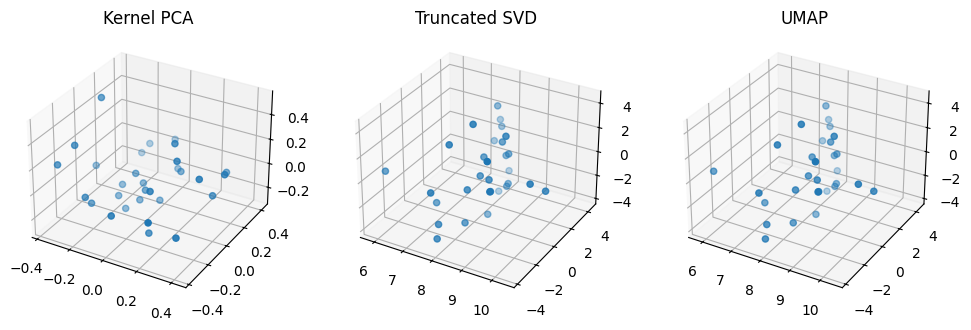

In [289]:
plot_3d(low_dim_embs, 30)

Предварительно можно предположить, что кластеры выходят довольно разреженными. Хотя датасет тоже наверное не самый наглядный

In [355]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [333]:
import operator

In [359]:
def imshow(images):

    l = len(images)
    fig, ax = plt.subplots(nrows=1, ncols=l, figsize = (12, 12))
    for i, im in enumerate(images):
        ax[i].imshow(im)

In [356]:
est = KMeans(n_clusters=5, )

In [357]:
preds = est.fit_predict(low_dim_embs[0], )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [365]:
preds

array([2, 2, 3, 3, 2, 2, 1, 1, 1, 4, 1, 1, 1, 4, 1, 4, 4, 4, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 3], dtype=int32)

In [358]:
adjusted_rand_score(classes, preds)

-0.06372155287817939

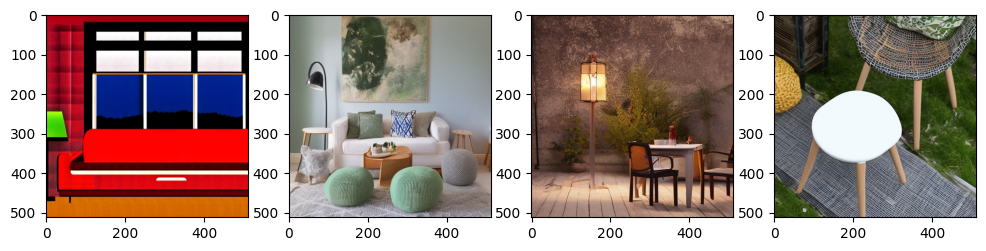

In [360]:
imshow(operator.itemgetter(*np.argwhere(preds==0).reshape(-1))(images))

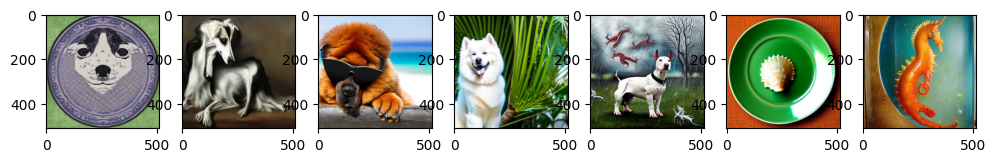

In [361]:
imshow(operator.itemgetter(*np.argwhere(preds==1).reshape(-1))(images))

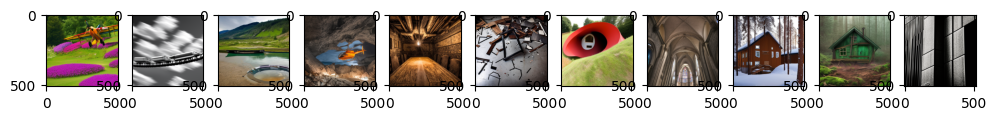

In [362]:
imshow(operator.itemgetter(*np.argwhere(preds==2).reshape(-1))(images))

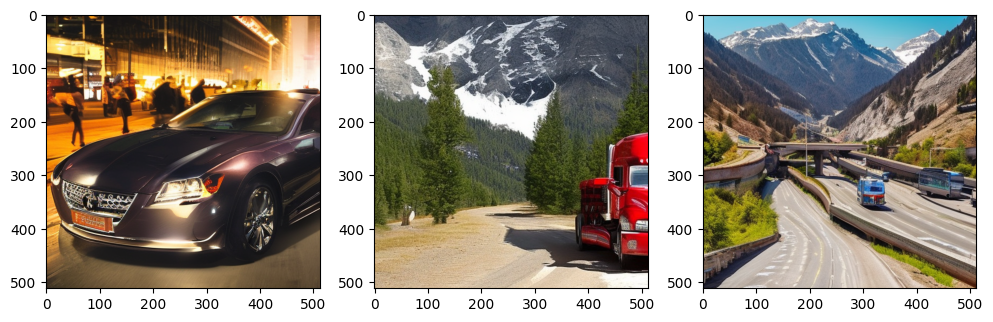

In [363]:
imshow(operator.itemgetter(*np.argwhere(preds==3).reshape(-1))(images))

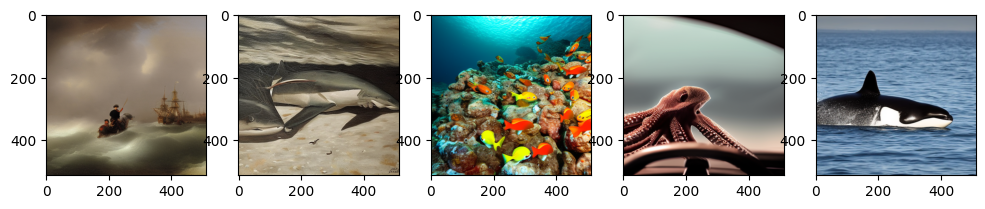

In [364]:
imshow(operator.itemgetter(*np.argwhere(preds==4).reshape(-1))(images))

### В целом, несмотря на не самые лучшие метрики (хотя для 30 примеров считать все же такое себе) -- классы выделяются довольно неплохо.

Есть некоторая группа мебели, животных, архитектурных/полуприродных объектов, где в целом доминируют ортогональные прямые линии; также некоторая группа автомобилей/сухопутного транспорта, подходящего для перемещения вне города, которая кластеризуется скорее отдельно от других видов транспорта (вероятно, в том числе в силу своей многочисленности в выборке, но и более своеобразной форме + возможному бэкграунду) и группа морских жителей.

### What if we clusterize in the input space without dim reduction

In [380]:
preds = est.fit_predict(image_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [381]:
adjusted_rand_score(classes, preds)

0.03496897913141568

Несмотря на чуть более высокое значение (в целом в пределах погрешности) кластеризация по всему многомерному пространству -- еще и KMeans-ом дело весьма неблагодарное. Неравенства концентрации дают о себе знать

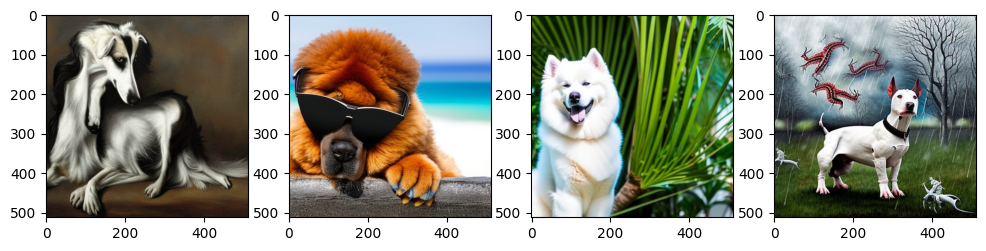

In [382]:
imshow(operator.itemgetter(*np.argwhere(preds==0).reshape(-1))(images))

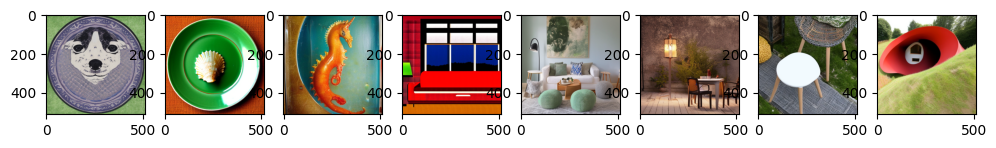

In [383]:
imshow(operator.itemgetter(*np.argwhere(preds==1).reshape(-1))(images))

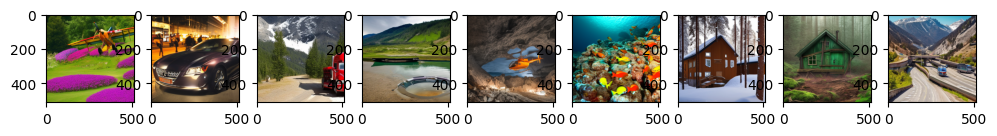

In [384]:
imshow(operator.itemgetter(*np.argwhere(preds==2).reshape(-1))(images))

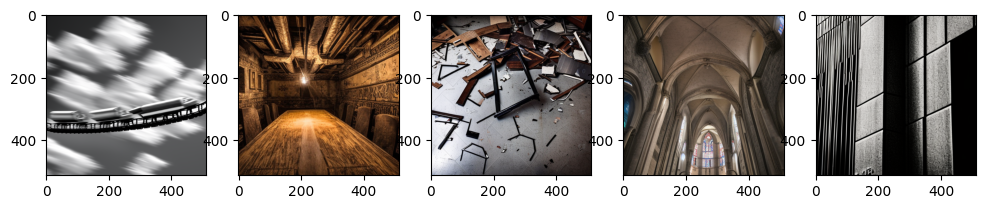

In [385]:
imshow(operator.itemgetter(*np.argwhere(preds==3).reshape(-1))(images))

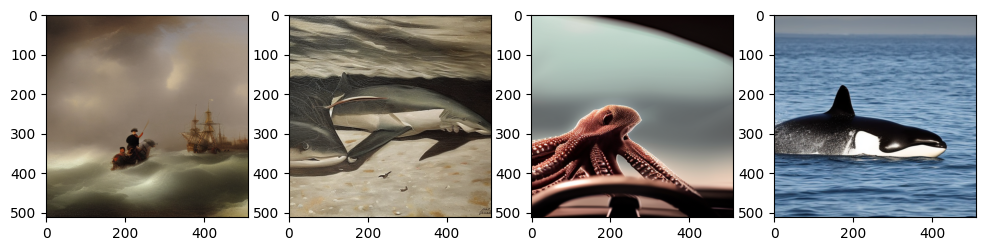

In [386]:
imshow(operator.itemgetter(*np.argwhere(preds==4).reshape(-1))(images))